# Function definitions

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FormatStrFormatter
import pandas as pd 
import plotly.express as px
import imageio
import datetime 
import os
pd.set_option('display.max_colwidth', None)

In [2]:
# Definition of the topic's weight in each group
def averageTopicInterest(data, topic, group):
    """
    Calculate the average topic interest in a given group.

    Args:
        data (DataFrame): The input data containing topic and partisan information.
        topic (str): The name of the topic column. We work with 10 topics, so topic takes values between 0 to 9
        group (str): The name of the group column. It can be FF or MP (Center-Left of Center-Right leaning)

    Returns:
        float: The weighted average of the topic's interest in the group.
    """
    return np.average(data[f'T{topic}'], weights=data[f'#{group}'])


def groupByOutlet(df_m):
    """
    Group the data by the outlet media and calculate differences in percentages.

    Args:
        df_m (DataFrame): The input DataFrame with data grouped by outlet.

    Returns:
        DataFrame: The grouped data with a 'difference' column, sorted by the difference in descending order.
    """
    # Group the data by outlet
    data_grouped_by_outlet = df_m.groupby('outlet').sum()

    # Rename columns for consistency
    if 'FF' in data_grouped_by_outlet.columns:
        data_grouped_by_outlet = data_grouped_by_outlet.rename(columns={'FF': '#FF'})
    if 'MP' in data_grouped_by_outlet.columns:
        data_grouped_by_outlet = data_grouped_by_outlet.rename(columns={'MP': '#MP'})

    # Calculate the difference between percentages to sort the data
    difference = (data_grouped_by_outlet['#FF'] / data_grouped_by_outlet['#FF'].sum()) - (data_grouped_by_outlet['#MP'] / data_grouped_by_outlet['#MP'].sum())

    # Add the 'difference' column and sort the data
    data_grouped_by_outlet['difference'] = difference
    data_grouped_by_outlet.sort_values(by='difference', inplace=True, ascending=False)

    return data_grouped_by_outlet

    
# Define the SB (Sentiment Bias) of a news article x. If there are no mentions of a candidate, SB is undefined.
def SB_Albanese2020(x):
    """
    Calculate the Sentiment Bias (SB) of a news item.

    Args:
        x (Series): A row (news item) from the input data with sentiment-related columns.

    Returns:
        float or NaN: The calculated SB if there are mentions, or NaN if no mentions are present.
    """
    ans = (x['pos_CL'] - x['neg_CL']) - (x['pos_CR'] - x['neg_CR'])
    norm = x['N_CL'] + x['N_CR']
    if norm != 0:
        return ans / norm
    else:
        return np.nan
    
def one_hot_encode(df, col='opinion'):
    """
    Encode a categorical column into one-hot columns with 1s and 0s.

    Args:
        df (DataFrame): The input DataFrame.
        col (str): The name of the column to be one-hot encoded.

    Returns:
        DataFrame: The input DataFrame with one-hot encoded columns.
    """
    one_hot = pd.get_dummies(df[str(col)])
    df = df.join(one_hot)
    return df

def add_accents(x):
    """
    Add accents to specific words in the input string.

    Args:
        x (str): The input string to add accents to.

    Returns:
        str: The input string with added accents.
    """
    x = x.replace('Pagina 12', 'Página 12').replace('Clarin', 'Clarín').replace('La Nacion', 'La Nación').replace('El Dia', 'El Día')
    return x


# Load and analyze data

In [3]:
df = pd.read_csv('data.csv')
df.head()

,date,url,outlet,dynamic_opinion,age,age_range,gender,tid,uid,hour,...,T3,T4,T5,T6,T7,T8,T9,month,week,day
0,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,NaN,NaN,NaN,1101346910135377920,716295311342321665,02:02:20,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
1,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,NaN,NaN,NaN,1101346845589233665,271519704,02:02:04,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
2,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,NaN,NaN,NaN,1101350580142903296,987494618156675072,02:16:55,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
3,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,NaN,NaN,NaN,1101350441126936580,770375532,02:16:21,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1
4,2019-03-01,https://www.clarin.com/politica/cristina-hijos-juicio-lavar-dinero-hoteles_0_K1h9GP1dX.html,Clarin,NaN,NaN,NaN,NaN,1101353444135370754,740350122974937088,02:28:17,...,0.029171,0.0,0.122224,0.0,0.0,0.0,0.0,3,9,1


In [4]:
# Filter tweets based on those posted by users with a defined political leaning.
df_opinion = df[df['dynamic_opinion'].isin(['FF','MP'])]

In [5]:
# Data by partisan opinion
df_CL = df[df['dynamic_opinion'] == 'FF']
df_CR = df[df['dynamic_opinion'] == 'MP']

In [6]:
# Describe dataset by partisan opinion

tCL = len(set(df_CL.tid))   # CL amount of tweets
uCL = len(set(df_CL.uid))   # CL amount of users
urlCL = len(set(df_CL.url)) # CL amount of news articles
tCR = len(set(df_CL.tid))   # CR amount of tweets
uCR = len(set(df_CL.uid))   # CR amount of users
urlCR = len(set(df_CL.url)) # CR amount of news articles

print('This dataset contains {} tweets from {} users intending to vote for the Center-Left (CL) coalition (Fernández-Fernández) and approximately {} tweets from {} users intending to vote for the Center-Right (CR) coalition (Macri-Pichetto). Intending CL coalition voters shared {} news articles, while intending CR voters shared {}.'.format(tCL,uCL,tCR,uCR,urlCL,urlCR))

This dataset contains 65727 tweets from 17349 users intending to vote for the Center-Left (CL) coalition (Fernández-Fernández) and approximately 65727 tweets from 17349 users intending to vote for the Center-Right (CR) coalition (Macri-Pichetto). Intending CL coalition voters shared 19276 news articles, while intending CR voters shared 19276.


In [7]:
medios_principales = ['Clarin', 'La Nacion', 'Todo Noticias', 'Infobae', 'Pagina 12', 'El Destape']

In [8]:
# Group and count articles in the main DataFrame by 'outlet' and sort descending
dfg = df.groupby('outlet').count().sort_values(by='tid', ascending=False).reset_index()

# Define the main outlets as the first 6 that are most frequently shared:
print('dfg: \n', dfg[['outlet','tid']].head(6))
main_outlets = dfg['outlet'][0:6].to_list()
print('\n main_outlets: ', main_outlets)

dfg: 
           outlet     tid
0     El Destape  307021
1         Clarin  160226
2        Infobae  141902
3      La Nacion  104183
4  Todo Noticias   95286
5      Pagina 12   76274

 main_outlets:  ['El Destape', 'Clarin', 'Infobae', 'La Nacion', 'Todo Noticias', 'Pagina 12']


In [9]:
# Group and count articles by political leaning and outlets
dfg_CL = df_CL.groupby('outlet').count().sort_values(by='date', ascending=False)['url']
dfg_CR = df_CR.groupby('outlet').count().sort_values(by='date', ascending=False)['url']

# Group and count unique articles by political leaning and outlets 
dfg_CL_unique = df_CL.drop_duplicates(['url']).groupby('outlet').count().sort_values(by='tid', ascending=False)['url']
dfg_CR_unique = df_CR.drop_duplicates(['url']).groupby('outlet').count().sort_values(by='tid', ascending=False)['url']

# Calculate the ratio of shared articles to unique articles for 'CL' and 'CR'
share_ratio_CL = [x / y for x, y in zip(dfg_CL, dfg_CL_unique)]
share_ratio_CR = [x / y for x, y in zip(dfg_CR, dfg_CR_unique)]

In [10]:
# Create a DataFrame of unique articles per outlet, then sort descending
urls_unique = df[['url', 'outlet']].drop_duplicates()
dfg_unique = urls_unique.groupby('outlet').count().sort_values(by='url', ascending=False)

# Calculate the ratio of shared articles to unique articles for all media outlets
urls_unique_list = dfg_unique['url'].to_list()
urls_shared = dfg.reindex(dfg_unique.index)['date']
share_ratio = [t / u for t, u in zip(urls_shared, urls_unique_list)]

# Create a copy of the DataFrame filtered for 'CL' and 'CR' opinion dynamics
df_dynamic = df[(df['dynamic_opinion'] == 'MP') | (df['dynamic_opinion'] == 'FF')].copy()

# Perform one-hot encoding for the 'opinion_dinamic' column
df_dynamic = one_hot_encode(df_dynamic, col='dynamic_opinion')

# Aggregate data by 'outlet' and calculate differences in percentages between amount of CL and CR users
data_aggregated_by_outlet = groupByOutlet(df_dynamic)

# Define a list of media indices in a specific order (combining data_aggregated_by_outlet.index with the criteria explaned in the paper)
media_indices = ['El Destape', 'Pagina 12', 'Minuto Uno', 'Ambito Financiero', 'La Izquierda Diario', 'Jornada', 'Contexto', 'El Litoral', 'Radio Dos', 'El Dia', 'Radio Mitre', 'El Cronista', 'Perfil', 'Todo Noticias', 'La Nacion', 'Infobae', 'Clarin']

# Reindex the aggregated data and unique articles data with the predefined indices
data_aggregated_by_outlet_reindexed = data_aggregated_by_outlet.reindex(index=media_indices)
dfg_unique_reindexed = dfg_unique.reindex(index=media_indices)
dfg_reindexed = dfg.reindex(index=media_indices)

# Calculate the fraction of unique articles 
total_unique_reindexed = sum(dfg_unique_reindexed['url'].to_list())
fraction_unique_reindexed = [(x / total_unique_reindexed) * 100 for x in dfg_unique_reindexed['url'].to_list()]

# Calculate the total number of shared articles for all media and the fraction
dfg_total = df.groupby('outlet').count().sort_values(by='date', ascending=False).reindex(index=media_indices)
total_shared = sum(dfg_total['url'].to_list())
fraction_shared = [(x / total_shared) * 100 for x in dfg_total['url'].to_list()]

# Define bold x-ticks for the plot
bold_xticks = [media_indices.index(m) for m in media_indices if m in main_outlets]

# Plot Figure

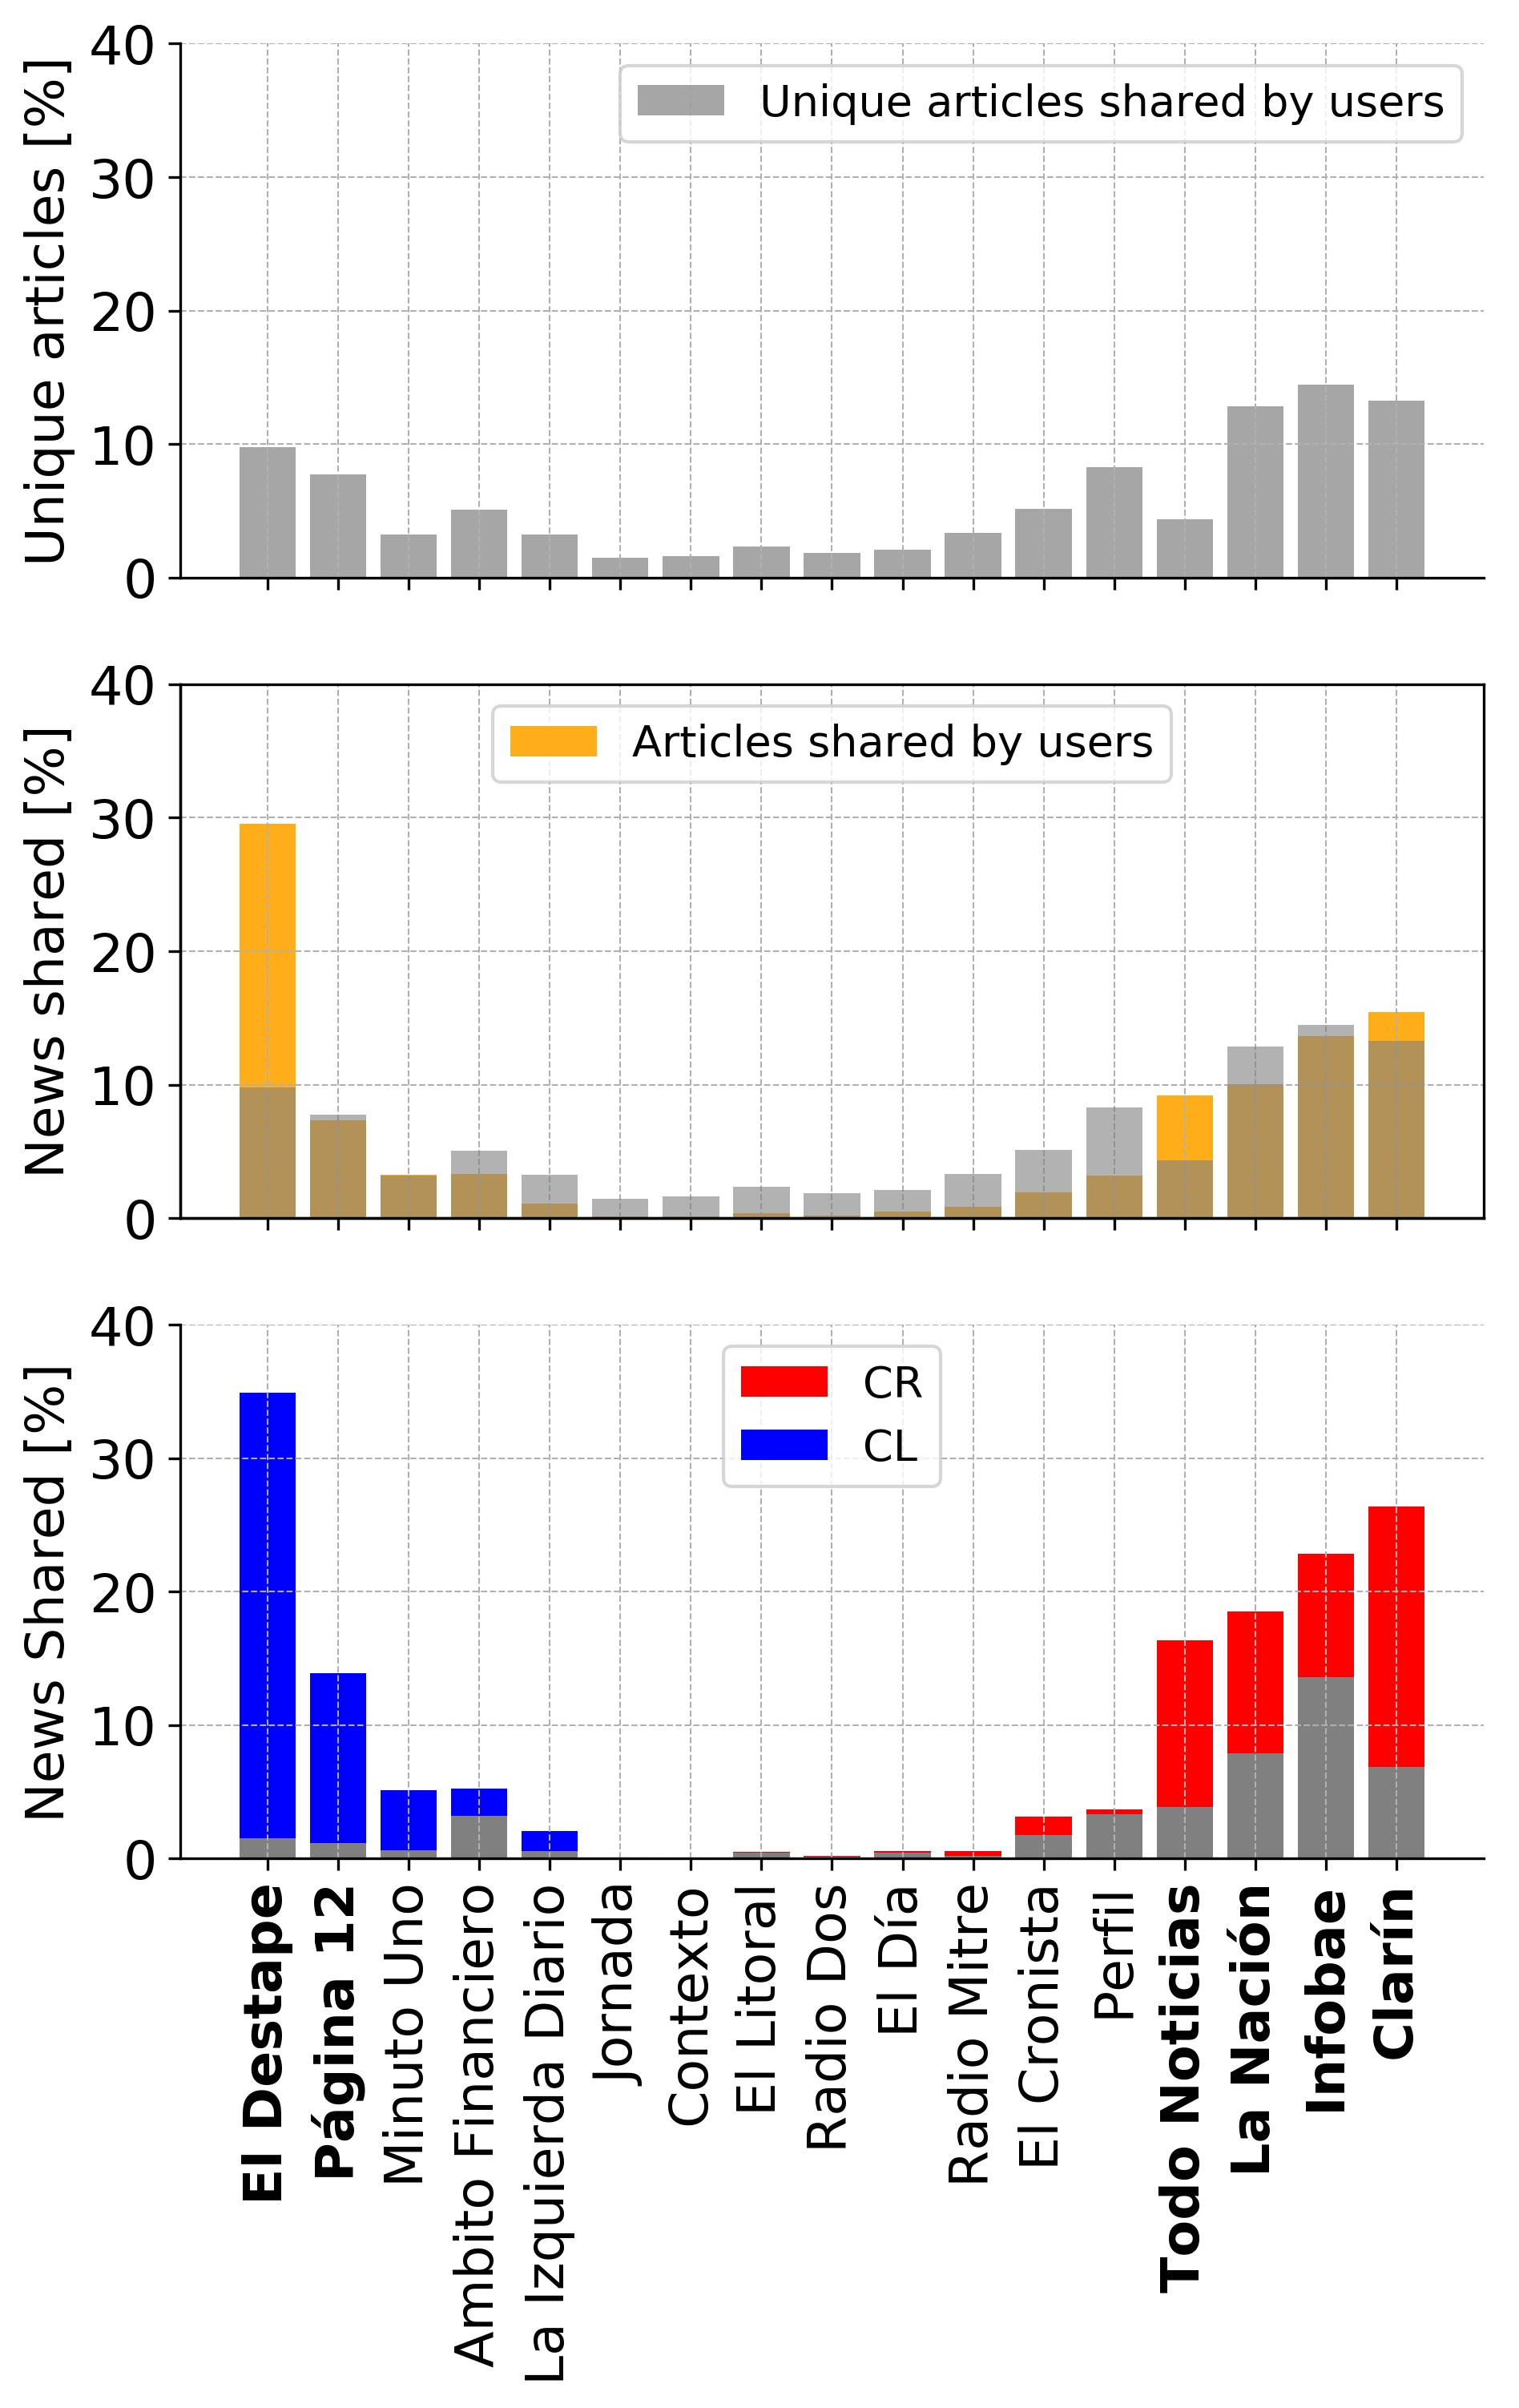

In [11]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True, figsize=(7,10),dpi = 300)
#Agrego tildes a medios:
indices = list(data_aggregated_by_outlet_reindexed.index)
medios_principales = [add_accents(m) for m in main_outlets]
indices = [add_accents(i) for i in indices]
bold_xticks = [indices.index(m) for m in indices if m in medios_principales]  # Index positions of the xticks to be bold

# Plot on the first subplot
ax1.bar(dfg_unique_reindexed.index.to_list(), fraction_unique_reindexed, color='grey', alpha = 0.7)
ax1.grid(linestyle='dashed', linewidth=0.5)
ax1.set_ylabel('Unique articles [%]', fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax1.yaxis.get_offset_text().set_fontsize(24)
ax1.legend(['Unique articles shared by users'], fontsize=13)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_tick_params(labelsize=16)
#ax1.spines['bottom'].set_visible(False)
#ax1.xaxis.set_ticks_position('none')
ax1.yaxis.get_offset_text().set_fontsize(24)
ax1.yaxis.set_tick_params(labelsize=16)  # Adjust the font size of the y-axis ticks
ax1.set_ylim([0,40])
# Create a twin y-axis for the second subplot
ax2_twin = ax2.twinx()

# Plot on the second subplot
ax2.bar(dfg_unique_reindexed.index.to_list(), fraction_shared, color='orange',alpha = 0.9, label = 'News shared [%]')
ax2_twin.bar(dfg_unique_reindexed.index.to_list(), fraction_unique_reindexed, color='grey', alpha = 0.6)
ax2.grid(linestyle='dashed', linewidth=0.5)
ax2.set_ylabel('News shared [%]', fontsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.legend(['Articles shared by users'],loc = 'upper center',fontsize = 13)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.ticklabel_format(style="sci", axis="y", scilimits=(0,2))  
ax2.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2_twin.set_yticks([])
ax2_twin.set_ylim([0,40])
ax2.set_ylim([0,40])


percent_MP = 100 * (data_aggregated_by_outlet_reindexed['#MP'] / data_aggregated_by_outlet_reindexed['#MP'].sum())
percent_FF = 100 * (data_aggregated_by_outlet_reindexed['#FF'] / data_aggregated_by_outlet_reindexed['#FF'].sum())
mins = np.minimum(percent_MP,percent_FF)
# Plot on the third subplot
ax3.bar(range(data_aggregated_by_outlet_reindexed.shape[0]), percent_MP, color='r', label='CR')
ax3.bar(range(data_aggregated_by_outlet_reindexed.shape[0]), percent_FF, color='b', label='CL')
ax3.bar(range(data_aggregated_by_outlet_reindexed.shape[0]),mins,color = 'grey') # , label = 'min(CL,CR)'
ax3.grid(linestyle='dashed', linewidth=0.5)
ax3.set_ylabel('News Shared [%]', fontsize=16)
ax3.tick_params(axis='both', labelsize=16)
ax3.set_xticks(range(data_aggregated_by_outlet_reindexed.shape[0]))
ax3.set_xticklabels(indices, rotation=90)


ax3.legend(loc='upper center',fontsize = 13)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(True)
ax3.set_ylim([0,40])
bold_font = FontProperties(weight='bold',size = 16)
for i, xtick in enumerate(ax3.get_xticklabels()):
    if i in bold_xticks:
        xtick.set_font_properties(bold_font)
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.2)

# Display the plot
plt.show()